In [1]:
import torch

# Check if CUDA is available and if so, which device is being used
if torch.cuda.is_available():
    print("CUDA is available.")
    device = torch.device('cuda')  # Set the device to GPU
    print('Running on the GPU:', torch.cuda.get_device_name())
else:
    print("CUDA is not available.")
    device = torch.device('cpu')  # Set the device to CPU
    print('Running on the CPU')

CUDA is available.
Running on the GPU: NVIDIA GeForce RTX 3090


# Environment Setting: CartPole-v1

In [2]:
env_name = 'CartPole-v1'

import gymnasium as gym
import tianshou as ts
import numpy as np
import pandas as pd

from tianshou.policy import DQNPolicy, QRDQNPolicy, C51Policy, RainbowPolicy
from tianshou.env import DummyVectorEnv
from tianshou.data import Collector, VectorReplayBuffer, PrioritizedVectorReplayBuffer
from tianshou.trainer import offpolicy_trainer
from tianshou.utils.net.discrete import NoisyLinear

env = gym.make(env_name)

train_envs = ts.env.DummyVectorEnv([lambda: gym.make(env_name) for _ in range(10)])
test_envs = ts.env.DummyVectorEnv([lambda: gym.make(env_name) for _ in range(100)])

2023-10-11 17:34:06.533803: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-11 17:34:06.581443: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-11 17:34:07.378101: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
import itertools
import functools
import scipy as sp
# from scipy.optimize import minimize
from scipy.special import logsumexp
from scipy.special import kl_div
import os
import random
from collections import namedtuple
from datetime import datetime
import copy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.parameter import Parameter
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
# from tqdm.autonotebook import tqdm

import pennylane as qml
from qiskit.quantum_info import partial_trace

# Variational Quantum Circuits: Pennylane library

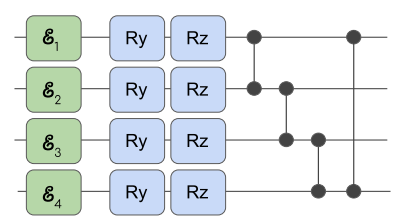

Each layer consists of a parametrized rotation along the Y and Z axes on each qubit, and a daisy chain of CZ gates. The green boxes correspond to data encoding gates that encode data as parameters of X rotations. When data reuploading is used, the whole circuit pictured is repeated in each layer, without data re-uploading only the variational part without the initial X rotations is repeated. (Skolik et al., 2022)

<br>

### References
Skolik, A., Jerbi, S., & Dunjko, V. (2022). Quantum agents in the Gym: a variational quantum algorithm for deep Q-learning. _Quantum_, 6, 720. DOI: 10.22331/q-2022-05-24-720 https://doi.org/10.22331/q-2022-05-24-720

In [4]:
def encode(n_qubits, inputs):
    """Encoding Layer"""
    for wire in range(n_qubits):
        qml.RX(inputs[wire], wires=wire)

def layer(n_qubits, y_weight, z_weight):
    """Parametrized Quantum Layers"""    
    for wire, y_weight in enumerate(y_weight):
        qml.RY(y_weight, wires=wire)
    for wire, z_weight in enumerate(z_weight):
        qml.RZ(z_weight, wires=wire)
    for wire in range(n_qubits):
        qml.CZ(wires=[wire, (wire + 1) % n_qubits])

def measure(n_qubits):
    """Measurement Layer"""
    return [
        qml.expval(qml.PauliZ(0) @ qml.PauliZ(1)),
        qml.expval(qml.PauliZ(2) @ qml.PauliZ(3))
    ]

def get_model(n_qubits, n_layers, data_reupload, return_val=True, rho_all=False, rho_A=False, prob=False):
    dev = qml.device("default.qubit", wires=n_qubits)
    shapes = {
        "y_weights": (n_layers, n_qubits),
        "z_weights": (n_layers, n_qubits)
    }
    @qml.qnode(dev, interface='torch')
    def circuit(inputs, y_weights, z_weights):
        for layer_idx in range(n_layers):
            if (layer_idx == 0) or data_reupload:
                encode(n_qubits, inputs)
            layer(n_qubits, y_weights[layer_idx], z_weights[layer_idx])
        if return_val:
            return measure(n_qubits)      # Expectation Value
        elif rho_all:
            return qml.density_matrix(wires=range(n_qubits))      # Density Matrix (all)
        elif rho_A:
            return qml.density_matrix(wires=[0, 1])      # Density Matrix (subsystem A with first two qubits)
        elif prob:
            return qml.probs(wires=range(n_qubits))      # Probability of each computational basis state
        else:
            return qml.state()      # Quantum State

    model = qml.qnn.TorchLayer(circuit, shapes) 
    model = model.cuda(device)
    
    return model

# Entanglement Metrics

## Log Negativity
Logarithmic negativity, one of the most well-known entanglement measure, has various applications in quantum information theory. For a bipartite state $\rho_{AB}$, its logarithmic negativity is defined as $$E_N(\rho_{AB}):= log||\rho^{T_B}_{AB}||_1.$$ where $\rho^{T_B}_{AB}$ is the partial transpose of the density matrix with respect to the subsystems B. (Wang et al., 2022)


## Coherent Information
Coherent information is a fundamental quantity that measures the capability of transition of quantum information. For an arbitrary bipartite quantum state $\rho∈\mathscr{H}_A⊗\mathscr{H}_B$, its coherent information is defined as $$I_C(\rho)=S(\rho_A)-S(\rho),$$ where $S(\rho)$ is the von Neumann entropy of $\rho$ and $\rho_A=Tr_B(\rho)$ is the subsystem in $\mathscr{H_A}$. 

<br>
A noteworthy characteristic of the coherent information is that for any bipartite $ρ$, it holds that $$E_F(ρ)≥E_D(ρ)≥I_C(ρ),$$ where $E_F(ρ)$ and $E_D(ρ)$ denote the entanglement of formation and the entanglement of distillation, respectively. As these are the two most important properties of quantum entanglement, we can obtain crucial information on the amount of entanglement for the quantum state $\rho$ by estimting coherent information $I_C(ρ)$. (Lin et al., 2023)

<br>

## Entangling Capacity
The entangling capability of a parameterized quantum circuit is characterized by the average Meyer-Wallach entanglement of the states it generates (Sim et al., 2019). This metric is evaluated by sampling the circuit parameters and calculating the sample average of the Meyer-Wallach measure for the resulting states. More precisely, we take the estimate of the entangling capability to be 
$$Ent = {1\over|S|} \sum_{\theta_i∈S}Q(|\phi_{\theta_i}),$$ 
where $S=\{\theta_i\}$ is the set of sampled circuit parameter vectors. A parameterized circuit exclusively generating product states will yield an entangling capability score of 0, whereas a circuit consistently producing highly entangled states will approach a score of 1. Intermediate cases will yield mean values between these extremes. For a detailed analysis of the circuit's ability to produce entangled states, statistical properties of the Q values' sample distribution, such as sample variance or higher statistical moments, can be computed. It's worth noting that the states generated during the expressibility assessment can be repurposed for estimating this entangling capability. (Sim et al., 2019)

<br>

### References:
Lin, X., Chen, Z., & Wei, Z. (2023). Quantifying quantum entanglement via a hybrid quantum-classical machine learning framework. _Physical Review A_, 107(6), 062409. DOI: 10.1103/PhysRevA.107.062409 https://link.aps.org/doi/10.1103/PhysRevA.107.062409
<br>
Wang, K., Song, Z., Zhao, X., Wang, Z., & Wang, X. (2022). Detecting and quantifying entanglement on near-term quantum devices. _npj Quantum Information_, 8(1), 52. DOI: 10.1038/s41534-022-00556-w https://doi.org/10.1038/s41534-022-00556-w
<br>
Sim, S., Johnson, P. D., & Aspuru-Guzik, A. (2019). Expressibility and Entangling Capability of Parameterized Quantum Circuits for Hybrid Quantum-Classical Algorithms. _Advanced Quantum Technologies_, 2(12), 1900070. DOI: https://doi.org/10.1002/qute.201900070 

In [5]:
def log_negativity(rho_all):
    """Log Negativity"""    
    rho = rho_all.detach().numpy()
    for i in range(8):
        for j in range(8,16):
            rho[[i, j], :] = rho[[j, i], :]
            
    for i in range(8):
        for j in range(8,16):
            rho[:, [i, j]] = rho[:, [j, i]]
            
    singular_values = np.linalg.svd(rho, compute_uv=False)
    trace_norm = np.sum(singular_values)
    return np.log2(trace_norm)

def coherent_info(rho_a, rho_all):
    return qml.math.vn_entropy(rho_a, indices=[0])-qml.math.vn_entropy(rho_all, indices=[0])

# def rel_ent_entangle(rho_all, sep):
#     def rel_entropy(sep):
#         return qml.math.relative_entropy(rho_all, sep)
    
#     initial_guess = np.random.rand(len(rho_all) * len(rho_all))
#     constraints = ({'type': 'ineq', 'fun': lambda sep: np.min(np.linalg.eigvals(np.reshape(sep, (len(rho_all), len(rho_all)))) - 1e-6)})
#     result = minimize(rel_entropy, initial_guess, constraints=constraints)
#     min_relative_entropy = result.fun
    
#     return min_relative_entropy

def entangle_cap(states, n_qubits):
    entangling_capability = []
    for i in range(len(states)):
        entropies = []
        entropy = 0
        qubit_list = list(range(n_qubits))
        
        for j in range(len(state_out[i])):
            state_vector = state_out[i][j]
            if isinstance(state_vector, torch.Tensor) and state_vector.requires_grad:
                state_vector = state_vector.detach().numpy()
            elif isinstance(state_vector, torch.Tensor):
                state_vector = state_vector.numpy()
            
            for k in range(n_qubits):
                rest = qubit_list[:k] + qubit_list[k+1:]
                dens = partial_trace(state_vector, rest).data
                trace = np.trace(np.matmul(dens, dens))
                entropy += trace.real
            entropy = entropy / n_qubits
            entropies.append(1.0-entropy)
        
        Q = 2*np.sum(entropies)/len(states)
        entangling_capability.append(Q)    
    
    return entangling_capability

# Expressibility

Expressibility refers to a quantum circuit's capacity to generate states within the Hilbert space effectively (Sim et al., 2019). In the context of a single qubit, this capability translates to the circuit's ability to explore the Bloch sphere comprehensively. One method to quantify expressibility involves comparing the states generated by varying the parameters of a Parametrized Quantum Circuit (PQC) with the uniform distribution of states, specifically, the ensemble of Haar-random states, renowned for its expressiveness. By utilizing the Haar ensemble as a benchmark, we satisfy our criteria for descriptors: computational simplicity and applicability across diverse problems. This approach leverages Haar ensemble properties, enabling the derivation of an efficient and problem-independent measure of expressibility. Although expressiveness is not obligatory for favorable algorithm performance, this definition allows for the identification of limited PQC structures, such as those generating product states, offering valuable insights into their capabilities.

<br>

After collecting sufficient samples of state fidelities, the Kullback–Leibler (KL) divergence, often used in machine learning applications, between the estimated fidelity distribution and that of the Haar-distributed ensemble can be computed to quantify expressibility (“Expr”) 
$$Expr = D_{KL}\left( \hat{P}_{PQC}(F;\theta)||P_{Haar}(F)\right)$$
where $\hat{P}_{PQC}(F;\theta)$ is the estimated probability distribution of fidelities resulting from sampling states from a PQC. We use discretization of the two probability distributions to estimate the KL divergence. This is because the probability distribution is estimated using a histogram due to a finite sample size.

Expressibility, when defined through KL divergence, provides a practical interpretation for this numerical metric. It quantifies the information loss incurred when approximating the distribution of state fidelities produced by a Parametrized Quantum Circuit (PQC) with that of Haar random states. (Sim et al., 2019)

<br>

### References:
Sim, S., Johnson, P. D., & Aspuru-Guzik, A. (2019). Expressibility and Entangling Capability of Parameterized Quantum Circuits for Hybrid Quantum-Classical Algorithms. _Advanced Quantum Technologies_, 2(12), 1900070. DOI: https://doi.org/10.1002/qute.201900070 

In [6]:
def prob_haar(fidelity, num_qubits) -> np.ndarray:
    """Returns probability density function of fidelities for Haar Random States"""
    return (2**num_qubits - 1) * (1 - fidelity + 1e-8) ** (2**num_qubits - 2)
    
def expressivity(states, num_qubits):
    express_out = []
    # Calculate fidelities from quantum states (generated from the Quantum RL model)    
    for i in range(len(states)):
        express = []
        for j in range(len(states[i])):
            fidelity = []
            for k in range(len(states[i])):
                fid = qml.math.fidelity(qml.math.dm_from_state_vector(states[i][j]), qml.math.dm_from_state_vector(states[i][k]))
                if isinstance(fid, torch.Tensor) and fid.requires_grad:
                    fid = fid.detach().numpy()
                elif isinstance(fid, torch.Tensor):
                    fid = fid.numpy()
                fidelity.append(fid)
            res = np.array(fidelity)
            haar = prob_haar(res, num_qubits)
            haar_prob: np.ndarray = haar / float(haar.sum())
            # Build histogram of distribution and evaluate KL divergence with Haar         
            bin_edges: np.ndarray
            pqc_hist, bin_edges = np.histogram(
                fidelity, len(states[i]), range=(0, 1), density=True
            )
            pqc_prob: np.ndarray = pqc_hist / float(pqc_hist.sum())
            express_i = kl_div(pqc_prob, haar_prob) 
            express.append(express_i)
        express_out.append(express)

#     if plot == True:
#         fig = plt.figure(figsize=(9.6, 6))

#         plt.ylim([1e-3, 1])
#         plt.ylabel(r"$Expr. D_{KL}$")
#         plt.xlabel("Repetitions")

#         plt.yscale('log')
#         plt.plot(len(states), express_out, marker='o', ls='--')
#         plt.tight_layout()
#         plt.show()

    return express_out

# Effective Dimension

Effective dimension serves as a pertinent metric in the realm of information geometry, embodying valuable attributes. Its fundamental purpose lies in gauging the space occupied by a model within the model space, a domain encompassing all conceivable functions pertinent to a specific model class. Here, the Fisher information matrix functions as the pivotal metric. Although numerous definitions of effective dimension exist, we adopt a particularly insightful one that is applicable to both classical and quantum models.

A pivotal determinant in these computations is the number of data observations, which inherently establishes a natural scale or resolution for observing the model space. This approach holds practical significance, especially in scenarios where data is scarce. Additionally, it provides valuable insights into the interplay between data availability and the accurate assessment of model complexity.

<br>
The effective dimension of a statistical model $M_Θ := {p(·, ·; θ) : θ ∈ Θ}$ with respect to $γ ∈ (0, 1]$, a _d_-dimensional parameter space $Θ ⊂ \mathscr{R}_d$ and $n ∈ N, n > 1$ data samples is defined as
$$ d_{\gamma, n}(M_Θ):= 2 {log \left({1\over V_Θ} \sqrt{det(id_d+{\gamma n \over 2 \pi log n} \hat{F}(\theta)} \, d\theta \right) \over log({\gamma n\over 2\pi log n})}$$
where $V_Θ:=\int_Θ dΘ∈{R}_+$ is the volume of the parameter space. $\hat{F}_\theta∈\mathscr{R}^{dxd}$ is the normalised Fisher information matrix defined as 
$$\hat{F}_{ij}(\theta):= d {V_Θ \over \int_Θ tr(F(\theta))d\theta} F_{ij}(\theta)$$,
where the normalisation ensures that ${1\over V_Θ}\int_Θ tr(\hat{F}(\theta))d\theta = d$.(Abbas et al., 2021)

<br>

### References
Abbas, A., Sutter, D., Zoufal, C., Lucchi, A., Figalli, A., & Woerner, S. (2021). The power of quantum neural networks. _Nature Computational Science_, 1(6), 403-409. DOI: 10.1038/s43588-021-00084-1 https://doi.org/10.1038/s43588-021-00084-1 https://arxiv.org/abs/2011.00027

In [7]:
def _torch_jac(circ):
    """Torch jacobian as a callable function"""
    import torch

    def wrapper(*args, **kwargs):
        loss = functools.partial(circ, **kwargs)
        if len(args) > 1:
            return torch.autograd.functional.jacobian(loss, args, create_graph=True)
        return torch.autograd.functional.jacobian(loss, *args, create_graph=True)

    return wrapper

def _compute_cfim(p, dp):
    r"""Computes the (num_params, num_params) classical fisher information matrix from the probabilities and its derivatives
    I.e. it computes :math:`classical_fisher_{ij} = \sum_\ell (\partial_i p_\ell) (\partial_i p_\ell) / p_\ell`
    """
    # Exclude values where p=0 and calculate 1/p
    nonzeros_p = qml.math.where(p > 0, p, qml.math.ones_like(p))
    one_over_p = qml.math.where(p > 0, qml.math.ones_like(p), qml.math.zeros_like(p))
    one_over_p = one_over_p / nonzeros_p
    # Multiply dp and p
    # Note that casting and being careful about dtypes is necessary as interfaces
    # typically treat derivatives (dp) with float32, while standard execution (p) comes in float64
    dp = qml.math.cast_like(dp, p)
    dp = qml.math.reshape(
        dp, (len(p), -1)
    )  # Squeeze does not work, as you could have shape (num_probs, num_params) with num_params = 1
    dp_over_p = qml.math.transpose(dp) * one_over_p  # creates (n_params, n_probs) array

    # (n_params, n_probs) @ (n_probs, n_params) = (n_params, n_params)
    return dp_over_p @ dp

def effective_dimension(circuit, input_params, n_qubits, n):
#     d = len(list(circuit.parameters()))
    d = len(input_params)
    j = _torch_jac(circuit)(input_params)
    if isinstance(j, tuple):
        res = []
        for j_i in j:
            res.append(_compute_cfim(input_params, j_i))
        if len(j) == 1:
            return res[0]

        return res
    fisher = _compute_cfim(circuit(input_params), j).detach().numpy()
    fisher_trace = np.trace(fisher)
#     avg_fisher = np.average(np.reshape(fisher, (len(input_params), n_qubits, d, d)), axis=1)
#     normalized_fisher = d * avg_fisher / fisher_trace
    normalized_fisher = d * fisher / fisher_trace

    dataset_size = n
    if not isinstance(dataset_size, int) and len(dataset_size) > 1:
        # expand dims for broadcasting
        normalized_fisher = np.expand_dims(normalized_fisher, axis=0)
        n_expanded = np.expand_dims(np.asarray(dataset_size), axis=(1, 2, 3))
        logsum_axis = 1
    else:
        n_expanded = np.asarray(dataset_size)
        logsum_axis = None

    # calculate effective dimension for each data sample size out
    # of normalized normalized_fisher
    f_mod = normalized_fisher * n_expanded / (2 * np.pi * np.log(n_expanded))
    one_plus_fmod = np.eye(d) + f_mod
    # take log. of the determinant because of overflow
    dets = np.linalg.slogdet(one_plus_fmod)[1]
    # divide by 2 because of square root
    dets_div = dets / 2
    effective_dims = (2
                      * (logsumexp(dets_div, axis=logsum_axis) - np.log(len(input_params)))
                      / np.log(dataset_size / (2 * np.pi * np.log(dataset_size)))
        )

    return np.squeeze(effective_dims)

# DQN Model: Tianshou library

In [8]:
LN_out = [] # Logarithmic Negativity
CI_out = [] # Coherent Information
state_out = []  # Quantum States
# REE_out = []  # Relative Entropy of Entanglement
vn_entropy_out = [] # von Neumann Entropy
ED_out = []  #Effective Dimension

In [9]:
class QuantumDQN(nn.Module):
    def __init__(self, n_qubits, n_actions, n_layers, w_input, w_output, data_reupload):
        super(QuantumDQN, self).__init__()
        self.n_qubits = n_qubits
        self.n_actions = n_actions
        self.n_layers = n_layers
        self.w_input = w_input
        self.w_output = w_output
        self.data_reupload = data_reupload
        self.q_layers = get_model(n_qubits=self.n_qubits,
                                  n_layers=n_layers,
                                  data_reupload=data_reupload,
                                  return_val=True)  # Set return_val=True to get the model
        self.rho_all = get_model(n_qubits=self.n_qubits,
                                  n_layers=n_layers,
                                  data_reupload=data_reupload,
                                  return_val=False, rho_all=True)  # Set rho_all=True to get the density matrix of all qubits
        self.rho_A = get_model(n_qubits=self.n_qubits,
                                  n_layers=n_layers,
                                  data_reupload=data_reupload,
                                  return_val=False, rho_A=True)  # Set rho_A=True to get the density matrix of subsystem A
        self.probs = get_model(n_qubits=self.n_qubits,
                                  n_layers=n_layers,
                                  data_reupload=data_reupload,
                                  return_val=False, prob=True)  # Set prob=True to get the probability distribution of all computational basis elements
        self.states = get_model(n_qubits=self.n_qubits,
                                  n_layers=n_layers,
                                  data_reupload=data_reupload,
                                  return_val=False)  # Set return_val=False to get the quantum states
        
        if w_input:
            self.w_input2 = Parameter(torch.Tensor(self.n_qubits))
            nn.init.normal_(self.w_input2, mean=0.)
        else:
            self.register_parameter('w_input', None)
        if w_output:
            self.w_output2 = Parameter(torch.Tensor(self.n_actions))
            nn.init.normal_(self.w_output2, mean=90.)
        else:
            self.register_parameter('w_output', None)

    def forward(self, inputs, **kwargs):
        batch_size = inputs.shape[0]  # Get the batch size
        outputs = []
        LN = []  # Logarithmic Negativity
        CI = []  # Coherent Information
        ED = []  # Effective Dimension
        entropy = []  # von Neumann Entropy
        state = []  # Quantum states
        
        for i in range(batch_size):
            input_i = inputs[i]  # Get the i-th input in the batch
            input_i = torch.tensor(input_i, dtype=torch.float32)  # Convert input_i to a PyTorch tensor
            if self.w_input2 is not None:
                input_i = input_i * self.w_input2
            input_i = torch.atan(input_i)
            output_i = self.q_layers(input_i)
            density_i = self.rho_all(input_i)
            density_A_i = self.rho_A(input_i)
            output_i = (1 + output_i) / 2
            
            LN_i = log_negativity(density_i)    # Logarithmic Negativity
            CI_i = coherent_info(density_A_i, density_i)     # Coherent Information
            entropy_i = qml.math.vn_entropy(density_i, indices=[0])     # von Neumann Entropy
            ED_i = effective_dimension(self.probs, input_i, self.n_qubits, 5000)     # Effective Dimension
            state_i = self.states(input_i)     # Quantum States
            
            outputs.append(output_i)
            LN.append(LN_i)
            CI.append(CI_i)
            entropy.append(entropy_i)
            ED.append(ED_i)
            state.append(state_i)

        outputs = torch.stack(outputs)  # Stack outputs along the batch dimension
        # entropy_out = torch.stack(entropy)
        LN_out.append(LN)
        CI_out.append(CI)
        ED_out.append(ED)
        vn_entropy_out.append(entropy)
        state_out.append(state)

        if self.w_output2 is not None:
            outputs = outputs * self.w_output2
        else:
            outputs = 90 * outputs
            outputs = outputs.view(-1, self.n_qubits * 2)

        return outputs, None

    def __deepcopy__(self, memodict={}):
        # Target Network: Create a new instance of the class
        new_instance = QuantumDQN(n_qubits = self.n_qubits,
                                      n_actions = self.n_actions,
                                      n_layers = self.n_layers,
                                      w_input = self.w_input,
                                      w_output = self.w_output,
                                      data_reupload = self.data_reupload)

        # Assign the quantum parts after copying
        new_instance.q_layers = copy.deepcopy(self.q_layers, memodict)
        new_instance.rho_all = copy.deepcopy(self.rho_all, memodict)
        new_instance.rho_A = copy.deepcopy(self.rho_A, memodict)
        new_instance.probs = copy.deepcopy(self.probs, memodict)
        new_instance.states = copy.deepcopy(self.states, memodict)
 
        return new_instance

In [10]:
# Use your defined network
state_shape = env.observation_space.shape[0]  # equivalent to 4 for CartPole-v1
action_shape = env.action_space.n  # equivalent to 2 for CartPole-v1

net = QuantumDQN(n_qubits=state_shape, n_actions=action_shape, n_layers=3, w_input=True, w_output=True, 
                     data_reupload=True)
# net = net.to(device)

optim = torch.optim.RMSprop(net.parameters(), lr=0.001)
policy = DQNPolicy(net, optim, discount_factor=0.99,
                       estimation_step=5,
                       target_update_freq=320, is_double=False)
# policy = policy.to(device)

buffer = VectorReplayBuffer(total_size=20000, buffer_num=10)  # max size of the replay buffer
train_collector = Collector(policy, train_envs, buffer, exploration_noise=True)
test_collector = Collector(policy, test_envs, exploration_noise=True)

In [11]:
from torch.utils.tensorboard import SummaryWriter
from tianshou.utils import TensorboardLogger
writer = SummaryWriter(f'log/CartPole_Quantum_DQN')
logger = TensorboardLogger(writer)

# Start training
result = offpolicy_trainer(
    policy,
    train_collector,
    test_collector,
    max_epoch=1,  # maximum number of epochs
    step_per_epoch=1000,  # number of steps per epoch
    step_per_collect=10,  # number of steps per data collection
    update_per_step=0.1,
    episode_per_test=1000,  # number of episodes per test
    batch_size=64,  # batch size for updating model
    train_fn=lambda epoch, env_step: policy.set_eps(0.1),
    test_fn=lambda epoch, env_step: policy.set_eps(0.05),
    stop_fn=lambda mean_rewards: mean_rewards >= env.spec.reward_threshold,
    logger=logger)

print(f'Finished training! Use {result["duration"]}')

/home/connectome/justin/.conda/envs/download_fs/lib/python3.8/site-packages/pennylane/qnn/torch.py:432: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at ../aten/src/ATen/native/Copy.cpp:276.)
  return res.type(x.dtype)
Epoch #1: 1001it [1:42:20,  6.13s/it, env_step=1000, len=10, loss=275.790, n/ep=2, n/st=10, rew=10.50]


Epoch #1: test_reward: 9.998000 ± 1.046898, best_reward: 12.285000 ± 1.586119 in #0
Finished training! Use 12417.56s


# Save Metrics Observations

In [12]:
def avg_per_iter(metric):
    ## Metrics: LN_out, CI_out, vn_entropy_out, ED_out
    mean = []
    for i in range(len(metric)):
        for j in range(len(metric[i])):
            x = metric[i][j]
            if isinstance(x, torch.Tensor) and x.requires_grad:
                x = x.detach().numpy()
            elif isinstance(x, torch.Tensor):
                x = x.numpy()
            metric[i][j] = x
        avg = np.mean(metric[i])
        mean.append(avg)
    return mean

In [13]:
express = expressivity(state_out, 4)
EC = entangle_cap(state_out, 4)

In [14]:
entangling_capability = pd.DataFrame(EC)
log_negativity = pd.DataFrame(avg_per_iter(LN_out))
coherent_info = pd.DataFrame(avg_per_iter(CI_out))
von_neumann = pd.DataFrame(avg_per_iter(vn_entropy_out))
effective_dim = pd.DataFrame(avg_per_iter(ED_out))
expressibility = pd.DataFrame(avg_per_iter(express))

In [15]:
metrics = pd.concat([log_negativity, coherent_info, von_neumann, effective_dim, expressibility, entangling_capability], 
                    axis=1)
metrics.columns = ["Log_Negativity", "Coherent_Information", "von_Neumann_Entropy", 
                   "Effective_Dimension", "Expressibility", "Entangling_Capability"]

metrics.to_csv(f'/scratch/connectome/justin/log_0/PennyLane_CartPole_Quantum_DQN_metrics.csv')
metrics

,Log_Negativity,Coherent_Information,von_Neumann_Entropy,Effective_Dimension,Expressibility,Entangling_Capability
0,-2.209977e-07,0.440490,0.178695,3.184766,0.041527,0.254718
1,-3.190279e-07,0.411261,0.206350,3.202267,0.041103,0.257203
2,-3.396659e-07,0.352219,0.264156,3.212885,0.043028,0.258513
3,-2.450753e-07,0.283326,0.332087,3.226814,0.039853,0.259463
4,-2.424956e-07,0.216161,0.398362,3.233553,0.039478,0.260794
...,...,...,...,...,...,...
631,-1.137305e-07,0.083381,0.524706,3.201889,0.102201,0.080045
632,-2.545344e-07,0.078622,0.529363,3.208429,0.123501,0.064319
633,-1.011663e-07,0.077045,0.530904,3.214275,0.163875,0.043588
634,-1.805818e-07,0.089102,0.519384,3.219531,0.233563,0.025615
